## Multimodal Transformer training: BERT + MLP

In [1]:
import pandas as pd
from time import time

import torch
import torch.nn as nn
from torch.optim import AdamW, lr_scheduler
from pytorch_lightning import Trainer
from torchmetrics.regression.r2 import R2Score
from utils.loss.rmse import RMSELoss

from tqdm import tqdm

from dataset import RegressionDataModule
from models.multimodal_transformer import MultimodalTransformerRegressor

c:\Users\Aaron\Documents\github\RentMate\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Hyperparameter tuning

In [2]:
BATCH_SIZE = 64 # 64
NUM_WORKERS = 4
LEARNING_RATE = 3e-3
EPOCHS = 8
WEIGHT_DECAY = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 2. Setup the Data Loaders

In [3]:
df = pd.read_csv('data/lat_long_preprocessed_data.csv')
model = "beto"
data_module = RegressionDataModule(df, batch_size=BATCH_SIZE  , model=model)
data_module.setup()

In [4]:
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

Get the number of dimensions of the numerical and categorical features:

In [5]:
numerical_features, categorical_features, input_ids, _, _ = next(iter(train_loader))

### 3. Setup the Model

In [6]:
model = MultimodalTransformerRegressor(cat_feat_dim=categorical_features.shape[1],
                                       numerical_feat_dim=numerical_features.shape[1])

MLP layer sizes:
 * Input: 802
 * Hidden: [200, 50, 12, 3]
 * Output: 1



In [7]:
model.to(DEVICE)

MultimodalTransformerRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [12]:
criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

### 4. Fit one batch to check that the model is learning "something" (optional)

In [9]:
numerical_features, categorical_features, input_ids, attention_mask, target = next(iter(train_loader))

# send this data to the GPU
numerical_features = numerical_features.to(DEVICE)
categorical_features = categorical_features.to(DEVICE)
input_ids = input_ids.to(DEVICE)
attention_mask = attention_mask.to(DEVICE)
target = target.to(DEVICE)

losses = []
maes = []


model.train()

print("Starting training process...")
ini_time = time()
for epoch in tqdm(range(EPOCHS), desc="Epoch: "):
    optimizer.zero_grad()
    output = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    categorical_features=categorical_features,
                    numerical_features=numerical_features)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    # scheduler.step()
    losses.append(loss.item())    
    mae = nn.L1Loss()(output, target)
    maes.append(mae.item())


print(f"Training took {time() - ini_time} seconds")

Starting training process...


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:07<?, ?it/s]


KeyboardInterrupt: 

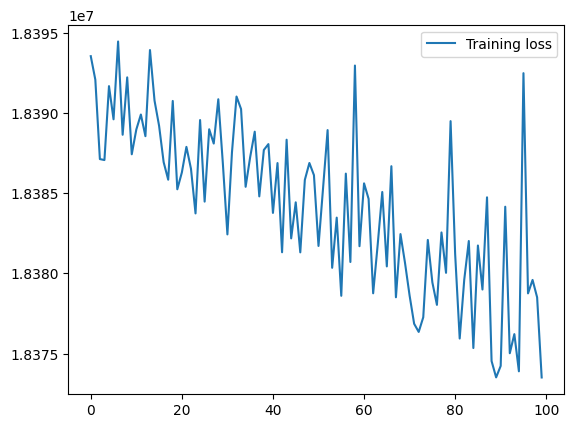

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot the loss over the EPOCHS using matplotlib
plt.plot(losses, label="Training loss")
plt.legend()
plt.show()

In [121]:
print(losses[0])

2041.6026611328125


### 5. Train the model

In [15]:
train_losses = []
val_losses = []
val_maes = []
val_mses = []
val_rmses = []
val_r2s = []

for epoch in range(EPOCHS):
    ##########################
    ######## TRAINING ########
    ##########################
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        numerical_features, categorical_features, input_ids, attention_mask, target = batch

        # move data to GPU
        numerical_features = numerical_features.to(DEVICE)
        categorical_features = categorical_features.to(DEVICE)
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        target = target.to(DEVICE)
        
        optimizer.zero_grad() # clear gradients, this is useful because gradients are accumulated

        # forward pass
        output = model(input_ids=input_ids,
                   attention_mask=attention_mask,
                   categorical_features=categorical_features,
                   numerical_features=numerical_features)
        
        loss = criterion(output, target) # calculate loss
        loss.backward() # calculate gradients
        optimizer.step() # update weights
        scheduler.step() # update learning rate
        train_loss += loss.item() # accumulate loss

    ##########################
    ####### VALIDATION #######
    ##########################
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    val_rmse = 0
    val_r2 = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            numerical_features, categorical_features, input_ids, attention_mask, target = batch

            # move data to GPU
            numerical_features = numerical_features.to(DEVICE)
            categorical_features = categorical_features.to(DEVICE)
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            target = target.to(DEVICE)

            # forward pass
            output = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    categorical_features=categorical_features,
                    numerical_features=numerical_features)
            
            # calculate loss and accumulate
            loss = criterion(output, target)
            val_loss += loss.item()
        
            # calculate metrics
            val_mae += nn.L1Loss()(output, target)
            val_mse += nn.MSELoss()(output, target)
            val_rmse += RMSELoss()(output, target)

            # move data to CPU and convert to numpy arrays
            output = output.cpu()
            target = target.cpu()
            val_r2 += R2Score()(output, target)

    # calculate average loss and metrics
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_maes.append(val_mae / len(val_loader))
    val_mses.append(val_mse / len(val_loader))
    val_rmses.append(val_rmse / len(val_loader))
    val_r2s.append(val_r2 / len(val_loader))

    # Save the model checkpoint
    torch.save(model.state_dict(), f"models/checkpoints/model_{epoch}.pt")

    # print the metrics and save them in a file
    print(f"Epoch {epoch} - Training loss: {train_loss / len(train_loader)} - Validation loss: {val_loss / len(val_loader)}")
    print(f"Epoch {epoch} - Validation MAE: {val_mae / len(val_loader)}")
    print(f"Epoch {epoch} - Validation MSE: {val_mse / len(val_loader)}")
    print(f"Epoch {epoch} - Validation RMSE: {val_rmse / len(val_loader)}")
    print(f"Epoch {epoch} - Validation R2: {val_r2 / len(val_loader)}")
    print("")

    with open("models/metrics.txt", "a") as f:
        f.write(f"Epoch {epoch} - Training loss: {train_loss / len(train_loader)} - Validation loss: {val_loss / len(val_loader)}\n")
        f.write(f"Epoch {epoch} - Validation MAE: {val_mae / len(val_loader)}\n")
        f.write(f"Epoch {epoch} - Validation MSE: {val_mse / len(val_loader)}\n")
        f.write(f"Epoch {epoch} - Validation RMSE: {val_rmse / len(val_loader)}\n")
        f.write(f"Epoch {epoch} - Validation R2: {val_r2 / len(val_loader)}\n")
        f.write("\n")

 52%|█████▏    | 13/25 [00:56<00:52,  4.35s/it]


KeyboardInterrupt: 